In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import expm
from scipy.sparse.linalg import expm_multiply
import sys
import os

from qiskit.quantum_info import random_hermitian, Statevector

from Certification import MyStateVector, certify

$$H_{\text{Rydberg}} = \frac{\Omega}{2}\sum_i X_i - \Delta \sum_i N_i + \Omega \sum_{i<j} \big(\frac{R_b}{a|i-j|}\big)^6 N_iN_j \text{ where } N_i \equiv |r_i\rangle\langle r_i|$$ 

In [5]:
def get_rydberg_hamiltonian(num_qubits, Omega, Delta, rb, a=1):
    N, d = num_qubits, 1 << num_qubits
    I = np.eye(2); X = np.array([[0,1],[1,0]]); Z = np.array([[1,0],[0,-1]]); Nop = (I - Z)/2
    def one(op,i):
        M = [I]*N; M[i] = op; out = M[0]
        for m in M[1:]: out = np.kron(out, m)
        return out
    def two(opA,i,opB,j):
        M = [I]*N; M[i], M[j] = opA, opB; out = M[0]
        for m in M[1:]: out = np.kron(out, m)
        return out
    H = np.zeros((d,d))
    for i in range(N): H += (Omega/2)*one(X,i) - Delta*one(Nop,i)
    for i in range(N):
        for j in range(i+1,N):
            H += Omega*(rb/(a*abs(i-j)))**6*two(Nop,i,Nop,j)
    return H

def get_random_product_state(num_qubits):
    state = 1
    for _ in range(num_qubits):
        v = np.random.randn(2) + 1j*np.random.randn(2)
        v /= np.linalg.norm(v)
        state = np.kron(state, v)
    return state

In [13]:
num_qubits_list = [3, 5, 7]
num_norms = 20
num_runs = 10000

Omega = 1
Delta = 2.5
rb = 1.5
tau = 0.1
a = 1

all_results = {}
all_fidelities = {}

for num_qubits in num_qubits_list:
    print(f"\nRunning for {num_qubits} qubits")
    H = get_rydberg_hamiltonian(num_qubits, Omega, Delta, rb, a).astype(complex)
    H_norm = np.linalg.norm(H)
    A_hyp = -1j * tau * H
    dim = 2**num_qubits

    norms = np.linspace(-H_norm * 0.25, H_norm * 0.25, num_norms)
    results = {norm: [] for norm in norms}
    fidelities = {norm: [] for norm in norms}

    total_jobs = num_norms * num_runs
    print(f"Total runs: {total_jobs}")
    start = time.time()

    for i, norm in enumerate(norms, 1):
        for run in range(1, num_runs + 1):
            psi0 = get_random_product_state(num_qubits) # random product state for each Certify run
            hyp = expm_multiply(A_hyp, psi0)

            P = random_hermitian(dim).data # random perturbation with fixed norm for each Certify run
            P /= np.linalg.norm(P)
            A_lab = -1j * tau * (H + norm * P)
            lab = expm_multiply(A_lab, psi0)

            cert_val = certify(MyStateVector(sv=Statevector(hyp)),
                               MyStateVector(sv=Statevector(lab)))
            fid_val = np.abs(np.vdot(hyp, lab))**2

            results[norm].append(cert_val)
            fidelities[norm].append(fid_val)

            if run % 10 == 0 or run == num_runs:
                elapsed = time.time() - start
                done = (i - 1) * num_runs + run
                msg = (f"Qubits: {num_qubits} | Norm {i}/{num_norms} | Run {run}/{num_runs} "
                       f"({done / total_jobs * 100:.1f}%)  Elapsed: {elapsed:.1f}s")
                sys.stdout.write("\r" + " " * 100 + "\r")
                sys.stdout.write(msg)
                sys.stdout.flush()

    sys.stdout.write("\r" + " " * 100 + "\r")
    print(f"Finished {num_qubits}-qubit run in {(time.time()-start)/60:.2f} min.")
    all_results[num_qubits] = results
    all_fidelities[num_qubits] = fidelities

print("\nAll runs complete.")


Running for 3 qubits
Total runs: 200000
Finished 3-qubit run in 7.90 min.                                                                   

Running for 5 qubits
Total runs: 200000
Finished 5-qubit run in 11.51 min.                                                                  

Running for 7 qubits
Total runs: 200000
Finished 7-qubit run in 61.83 min.                                                                  

All runs complete.


In [ ]:
# os.makedirs("rydberg_results", exist_ok=True)

# for num_qubits in all_results:
#     np.savez(
#         f"rydberg_results/results_{num_qubits}q_{num_runs}runs.npz",
#         norms=np.array(list(all_results[num_qubits].keys())),
#         certs=np.array([np.array(v) for v in all_results[num_qubits].values()], dtype=object),
#         fidelities=np.array([np.array(v) for v in all_fidelities[num_qubits].values()], dtype=object),
#     )

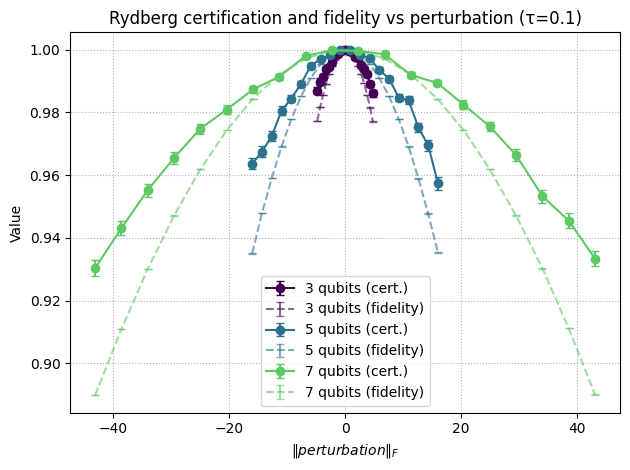

In [23]:
colors = plt.cm.viridis(np.linspace(0, 0.75, len(all_results)))

for color, num_qubits in zip(colors, all_results.keys()):
    cert_results = all_results[num_qubits]
    fid_results = all_fidelities[num_qubits]

    xs, ps, errs = [], [], []
    xf, pf, erf = [], [], []

    for n in sorted(cert_results.keys()):
        cert_arr = np.asarray(cert_results[n], dtype=float)
        fid_arr = np.asarray(fid_results[n], dtype=float)

        xs.append(n)
        ps.append(cert_arr.mean())
        errs.append(cert_arr.std(ddof=1) / np.sqrt(len(cert_arr)))

        xf.append(n)
        pf.append(fid_arr.mean())
        erf.append(fid_arr.std(ddof=1) / np.sqrt(len(fid_arr)))

    plt.errorbar(xs, ps, yerr=errs, fmt='o-', capsize=3, color=color, label=f"{num_qubits} qubits (cert.)")
    plt.errorbar(xf, pf, yerr=erf, fmt='--', capsize=3, color=color, alpha=0.6, label=f"{num_qubits} qubits (fidelity)")

plt.xlabel(r"$\| perturbation \|_F$")
plt.ylabel("Value")
plt.title(f"Rydberg certification and fidelity vs perturbation (τ={tau})")
plt.legend(ncol=1)
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

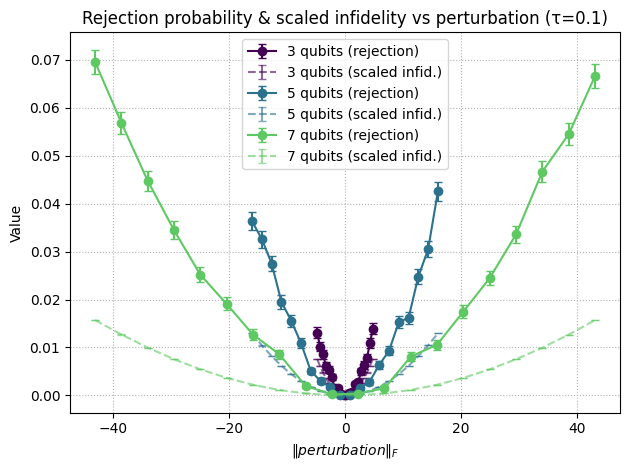

In [22]:
colors = plt.cm.viridis(np.linspace(0, 0.75, len(all_results)))

for color, num_qubits in zip(colors, all_results.keys()):
    cert_results = all_results[num_qubits]
    fid_results = all_fidelities[num_qubits]

    xs, rej_ps, rej_errs = [], [], []
    xf, inf_ps, inf_errs = [], [], []

    for n in sorted(cert_results.keys()):
        cert_arr = np.asarray(cert_results[n], float)
        fid_arr = np.asarray(fid_results[n], float)

        # rejection probability = 1 - acceptance
        rej = 1 - cert_arr
        xs.append(n)
        rej_ps.append(rej.mean())
        rej_errs.append(rej.std(ddof=1) / np.sqrt(len(rej)))

        # scaled infidelity = (1 - fidelity) / num_qubits
        inf = (1 - fid_arr) / num_qubits
        xf.append(n)
        inf_ps.append(inf.mean())
        inf_errs.append(inf.std(ddof=1) / np.sqrt(len(inf)))

    # rejection probability (solid)
    plt.errorbar(xs, rej_ps, yerr=rej_errs, fmt='o-', capsize=3,
                 color=color, label=f"{num_qubits} qubits (rejection)")

    # scaled infidelity (dashed)
    plt.errorbar(xf, inf_ps, yerr=inf_errs, fmt='--', capsize=3,
                 color=color, alpha=0.6, label=f"{num_qubits} qubits (scaled infid.)")

plt.xlabel(r"$\| perturbation \|_F$")
plt.ylabel("Value")
plt.title(f"Rejection probability & scaled infidelity vs perturbation (τ={tau})")
plt.legend(ncol=1)
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()